# Notebook used to visualize the mean instantenous power consumed by the labeled electrical components, as depicted in the data descriptor

## Load packages and basic dataset information

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import patches
            
import matplotlib
%matplotlib inline

import h5py
import pandas as pd
import os
import sys
from pathlib import Path
from datetime import datetime
from datetime import timedelta
import math
import seaborn as sns
import pdb
import scipy
# Add project path to path for import
project_path = os.path.abspath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

# Add module path to path for import
module_path = os.path.abspath("../data_utility/data_utility.py")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_utility import CREAM_Day # class to work with a day of the CREAM Dataset

# Intentional replication is necessary
%load_ext autoreload
# Reload all modules every time before executing the Python code typed.
%autoreload 2 
# Import some graphical modules
from IPython.display import display, clear_output
from ipywidgets import Button, Layout, ButtonStyle, HBox, VBox, widgets, Output
from IPython.display import SVG, display, clear_output

import subprocess
import glob

In [ ]:
PATH_TO_DATA = os.path.abspath(os.path.join("..", "..", "Datasets", "CREAM"))
ALL_DAYS = ["2018-08-23" , "2018-08-24" , "2018-08-25",  "2018-08-26" , "2018-08-27" , "2018-08-28" ,
"2018-08-29", "2018-08-30", "2018-08-31", "2018-09-01", "2018-09-02" , "2018-09-03" ,  "2018-09-04" ,
"2018-09-05", "2018-09-06", "2018-09-07", "2018-09-08" , "2018-09-09" , "2018-09-10", "2018-09-11", "2018-09-12" 
"2018-09-13" ,"2018-09-14" ,"2018-09-15" ,  "2018-09-16", "2018-09-17", "2018-09-18","2018-09-19"  , "2018-09-20" ,
"2018-09-21" , "2018-09-22" ,  "2018-09-23" ,"2018-09-24" ,"2018-09-25" ,"2018-09-26" , "2018-09-27", "2018-09-28" ,
"2018-09-29" , "2018-09-30" , "2018-10-01" ,"2018-10-02" , "2018-10-03" ,"2018-10-04", "2018-10-05" , "2018-10-06" ,
"2018-10-07", "2018-10-08" ]

In [ ]:
#necessary for the plotting
# Load the events 
day_path = os.path.join(PATH_TO_DATA, "2018-08-24") #arbitrary day to initialize the object
current_CREAM_day = CREAM_Day(cream_day_location=day_path,use_buffer=True, buffer_size_files=2) 

# Load the electrical component events (the raw ones)
all_component_events = current_CREAM_day.load_component_events(os.path.join(PATH_TO_DATA, "component_events.csv"), filter_day=False)

# Load the product and the maintenance events (the raw ones, per minute events) and filter for the day
all_maintenance_events = current_CREAM_day.load_machine_events(os.path.join(PATH_TO_DATA, "maintenance_events.csv"), raw_file=False, filter_day=False)
all_product_events = current_CREAM_day.load_machine_events(os.path.join(PATH_TO_DATA, "product_events.csv"), raw_file=False, filter_day=False)


# Plot the mean instantantenous power of the labeled electrical components, i.e., heater, millingplant and pump

### Due to the number of heater events, we sample 100 events of each component to compute the mean power

In [ ]:
mean_instant_power_list = []
component_list = []
x_axis = [] # x-axis, first component at 1, second at 2, third at 3
for index, component in enumerate( np.unique(all_component_events.Component), start=1):
    if component == "unlabeled": #skip the unlabeled ones
        continue
        
    component_events = all_component_events[all_component_events.Component == component]
    
    component_events = component_events.sample(n=100, random_state=10)
    # for efficienfy reasons, iterate over each day separately
    for day_date in np.unique(component_events.Date):
              
        for event in component_events[component_events.Date == day_date].itertuples():
            cream_day = CREAM_Day(cream_day_location=os.path.join(PATH_TO_DATA, str(day_date)), use_buffer=True, buffer_size_files=10)
            voltage, current = cream_day.load_time_frame(event.Timestamp, duration=0.5, return_noise=False)
            instant_power = voltage * current
            mean_instant_power_list.append(np.mean(instant_power))
            component_list.append(component)
            x_axis.append(index)

component_list = np.array(component_list)
mean_instant_power_list = np.array(mean_instant_power_list)


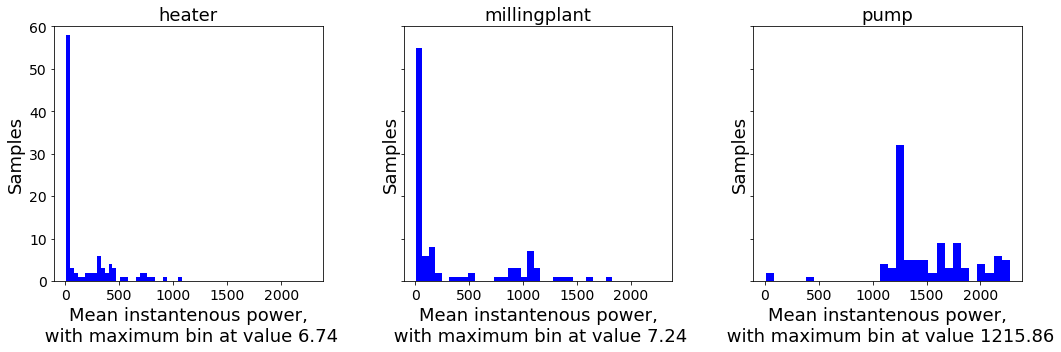

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
for i, component in enumerate(np.unique(component_list)):
    mask = np.where(component_list == component)[0]
    hist, bins = np.histogram(mean_instant_power_list[mask], bins=30)
    biggest_bin = np.argmax(hist) # get biggest bin and its value
    x, y, _ = ax[i].hist(mean_instant_power_list[mask], bins, color="b")
   
    max_bin = np.argmax(x)
    max_value = y[max_bin]
    
    
    ax[i].set_title(component, fontsize=18)
    ax[i].set_ylim(0,60)
    ax[i].set_ylabel("Samples", fontsize=18)
    ax[i].set_xlabel("Mean instantenous power,\n with maximum bin at value %.2f" %(max_value), fontsize=18)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].tick_params(axis='both', which='minor', labelsize=10)

fig.tight_layout()
fig.savefig("./Figure_4.pdf")
plt.show()
